In [1]:
import pandas as pd
import numpy as np
import requests
import json
from config import api_key
import flr_tools
import cme_tools
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime

In [41]:
start_date = "2001-01-01"
end_date = "2019-09-30"
#query_flr_url =f"https://api.nasa.gov/DONKI/FLR?startDate={start_date}&endDate={end_date}&api_key={api_key}"

In [42]:
dont_use_nasa_time_format = False
flare_alldf = flr_tools.flare_query_all(start_date, end_date, dont_use_nasa_time_format)
flare_alldf.head()

,class_type,end_time(zulu),flare_id,linked_events,peak_time(zulu),power(w/m^2),start_time(zulu)
0,B7.4,"04/03/2010, 10:58:00",2010-04-03T09:04:00-FLR-001,[{'activityID': '2010-04-03T09:54:00-CME-001'}],"04/03/2010, 09:54:00",7.400000e-07,"04/03/2010, 09:04:00"
1,M2.0,"06/12/2010, 01:02:00",2010-06-12T00:30:00-FLR-001,[None Found.],"06/12/2010, 00:57:00",2.000000e-05,"06/12/2010, 00:30:00"
2,M1.0,"08/07/2010, 18:47:00",2010-08-07T17:55:00-FLR-001,[None Found.],"08/07/2010, 18:24:00",1.000000e-05,"08/07/2010, 17:55:00"
3,C4.4,"08/14/2010, 10:31:00",2010-08-14T09:38:00-FLR-001,[{'activityID': '2010-08-14T12:30:00-SEP-001'}],"08/14/2010, 10:05:00",4.400000e-06,"08/14/2010, 09:38:00"
4,C4.5,"08/18/2010, 06:51:00",2010-08-18T04:45:00-FLR-001,[{'activityID': '2010-08-18T06:00:00-CME-001'}],"08/18/2010, 05:48:00",4.500000e-06,"08/18/2010, 04:45:00"


In [43]:
dont_use_nasa_time_format = False
cme_alldf = cme_tools.cme_query_all(start_date, end_date, dont_use_nasa_time_format)
cme_alldf.head()

,cme_id,speed,type,linked_events,start time
0,2010-04-03T09:54:00-CME-001,620,C,[{'activityID': '2010-04-03T09:04:00-FLR-001'}...,"04/03/2010, 09:54:00"
1,2010-06-13T07:32:00-CME-001,500,C,None,"06/13/2010, 07:32:00"
2,2010-06-20T03:18:00-CME-001,570,C,[{'activityID': '2010-06-23T08:00:00-IPS-001'}],"06/20/2010, 03:18:00"
3,2010-07-03T01:30:00-CME-001,625,C,None,"07/03/2010, 01:30:00"
4,2010-07-08T22:30:00-CME-001,290,S,None,"07/08/2010, 22:30:00"


In [5]:
cme_ids = cme_tools.linked_events(flare_alldf.rename(columns={'flare_id':'id'}),'CME')
flr_ids = cme_tools.linked_events(cme_alldf.rename(columns={'cme_id':'id'}),'FLR')
both = pd.DataFrame(cme_ids, columns=['flare_id','cme_id'])
new_df = both.merge(cme_alldf[["cme_id","speed","type","start time"]], on="cme_id", how='left')
new_df = new_df.rename(columns={"speed":"cme speed","type": "cme type", "start time": "cme start time"})
full_df = new_df.merge(flare_alldf[["flare_id","start_time(zulu)","peak_time(zulu)","end_time(zulu)","class_type","power(w/m^2)"]],
                      on="flare_id", how="left")
full_df = full_df.rename(columns={"start_time(zulu)":"flare start time","peak_time(zulu)": "flare peak time",
                                  "end_time(zulu)":"flare end time","class_type":"flare type","power(w/m^2)":"flare power(w/m^2)"})
full_df.head()

,flare_id,cme_id,cme speed,cme type,cme start time,flare start time,flare peak time,flare end time,flare type,flare power(w/m^2)
0,2014-01-04T18:47:00-FLR-001,2014-01-04T21:25:00-CME-001,750,C,"01/04/2014, 21:25:00","01/04/2014, 18:47:00","01/04/2014, 19:46:00","01/04/2014, 20:23:00",M4.0,0.000040
1,2014-01-04T22:12:00-FLR-001,2014-01-05T00:54:00-CME-001,650,C,"01/05/2014, 00:54:00","01/04/2014, 22:12:00","01/04/2014, 22:52:00","01/04/2014, 23:22:00",M1.9,0.000019
2,2014-01-07T18:02:00-FLR-001,2014-01-07T18:24:00-CME-001,2061,R,"01/07/2014, 18:24:00","01/07/2014, 18:02:00","01/07/2014, 18:32:00","01/07/2014, 18:58:00",X1.2,0.000120
3,2014-01-08T03:39:00-FLR-001,2014-01-08T04:12:00-CME-001,472,S,"01/08/2014, 04:12:00","01/08/2014, 03:39:00","01/08/2014, 03:47:00","01/08/2014, 03:54:00",M3.6,0.000036
4,2014-01-27T01:05:00-FLR-001,2014-01-27T02:24:00-CME-001,700,C,"01/27/2014, 02:24:00","01/27/2014, 01:05:00","01/27/2014, 01:21:00","01/27/2014, 01:39:00",M1.0,0.000010


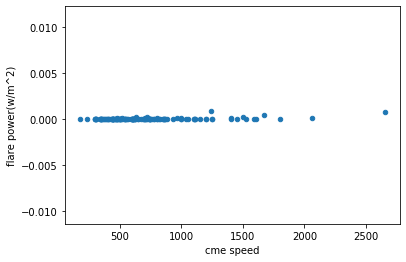

In [6]:
full_df["cme speed"] = pd.to_numeric(full_df["cme speed"], errors="coerce")
full_df["flare power(w/m^2)"] = pd.to_numeric(full_df["flare power(w/m^2)"], errors="coerce")

full_df.plot(kind="scatter", x="cme speed", y="flare power(w/m^2)")

(3.1e-07, 0.001)

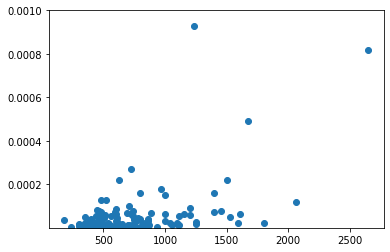

In [7]:
plt.scatter(full_df["cme speed"], full_df["flare power(w/m^2)"])
plt.ylim(full_df["flare power(w/m^2)"].min(), 10*10**-4)

In [9]:
cme_alldf["speed"] = pd.to_numeric(cme_alldf["speed"], errors="coerce")
flare_alldf["power(w/m^2)"] = pd.to_numeric(flare_alldf["power(w/m^2)"], errors="coerce")

In [10]:
new_df = full_df.dropna(how="any")

In [11]:
tstat,p = stats.ttest_ind(new_df["cme speed"], new_df["flare power(w/m^2)"], equal_var = False)

In [12]:
print(tstat,p)

21.34416423808531 1.2443141034431102e-44


([<matplotlib.axis.XTick at 0x1d28cf2aa20>,
 <a list of 3 Text xticklabel objects>)

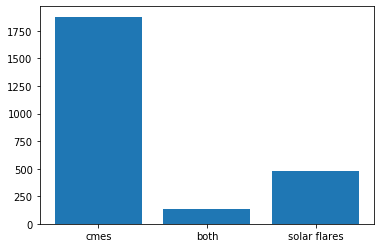

In [13]:
object_list = ["cmes", "both","solar flares"]
counts = [len(cme_alldf), len(full_df), len(flare_alldf)]
plt.bar(np.arange(len(object_list)),counts, align="center")
plt.xticks(np.arange(len(object_list)),object_list)

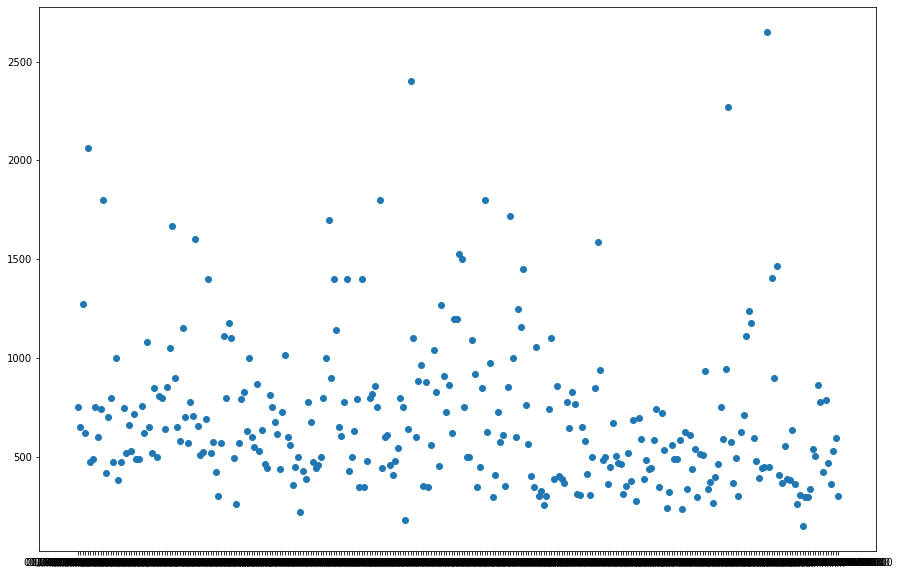

In [14]:
plt.figure(figsize=(15,10))
cme_clean_df = cme_alldf.dropna(how="any")

plt.scatter(cme_clean_df["start time"], cme_clean_df['speed'])
plt.show()

In [ ]:
dates = full_df["cme start time"]



In [ ]:
dt.strptime(dates[0], '%m/%d/%Y, %H:%M:%S').strftime("%m/01/%Y")

In [ ]:
speed_groups = cme_alldf[['type','speed']].dropna(how='any').groupby("type")

In [ ]:
speed_cats = pd.DataFrame(speed_groups.min()).merge(speed_groups.max(), on='type')
speed_cats = speed_cats.rename(columns={"speed_x":"min speed", "speed_y":"max speed"})
cme_speed_categories = speed_cats.drop("NA").sort_values("min speed", ascending=True)
cme_speed_categories

In [16]:
sunspots = pd.read_csv("../data/daily_area.txt",delim_whitespace=True)

In [17]:
sunspots.head()

,YYYY,MM,DD,Total,North,South
0,1874,5,1,-1.0,-1.0,-1.0
1,1874,5,2,-1.0,-1.0,-1.0
2,1874,5,3,-1.0,-1.0,-1.0
3,1874,5,4,-1.0,-1.0,-1.0
4,1874,5,5,-1.0,-1.0,-1.0


In [ ]:
print(datetime.datetime(int(sunspots.iloc[0]['YYYY']),int(sunspots.iloc[0]['MM']), 1).strftime("%Y-%m-%d"))

In [24]:
months = []
for i,row in sunspots.iterrows():
    months.append(datetime.datetime(int(row['YYYY']),int(row['MM']), 1).strftime("%Y-%m-%d"))

In [25]:
months

['1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-07-01',
 '1874-07-01',
 '1874-07-01',
 '1874-07-01',
 '1874-07-01',
 '1874-07-

In [18]:
small_sun = sunspots.loc[sunspots["YYYY"] >=2014]

In [22]:
small_sun

,YYYY,MM,DD,Total,North,South
51014,2014,1,1,686.0,28.0,658.0
51015,2014,1,2,854.0,28.0,826.0
51016,2014,1,3,1974.0,56.0,1918.0
51017,2014,1,4,2198.0,56.0,2142.0
51018,2014,1,5,2394.0,70.0,2324.0
51019,2014,1,6,2506.0,154.0,2352.0
51020,2014,1,7,2597.0,364.0,2233.0
51021,2014,1,8,2590.0,420.0,2170.0
51022,2014,1,9,2786.0,490.0,2296.0
51023,2014,1,10,2744.0,546.0,2198.0


In [26]:
months


['1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-05-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-06-01',
 '1874-07-01',
 '1874-07-01',
 '1874-07-01',
 '1874-07-01',
 '1874-07-01',
 '1874-07-

In [36]:
unique_months = {}

for month in months:
    if month not in unique_months.keys():
        unique_months[month] = 0

In [29]:
month

'1874-05-01'

In [31]:
unique_months.keys()

dict_keys([])

In [34]:
unique_months[month] =0 

In [38]:
unique_months['1956-03-01']

0

In [39]:
for i, row in sunspots.iterrows():
    unique_months[datetime.datetime(int(row['YYYY']),int(row['MM']), 1).strftime("%Y-%m-%d")] = unique_months[datetime.datetime(int(row['YYYY']),int(row['MM']), 1).strftime("%Y-%m-%d")] + row['Total']

In [40]:
unique_months

{'1874-05-01': 8389.0,
 '1874-06-01': 10375.0,
 '1874-07-01': 32039.0,
 '1874-08-01': 29578.0,
 '1874-09-01': 10058.0,
 '1874-10-01': 12870.0,
 '1874-11-01': 11630.0,
 '1874-12-01': 2872.0,
 '1875-01-01': 2239.0,
 '1875-02-01': 11177.0,
 '1875-03-01': 13114.0,
 '1875-04-01': 11815.0,
 '1875-05-01': 4508.0,
 '1875-06-01': 13165.0,
 '1875-07-01': 2380.0,
 '1875-08-01': 3851.0,
 '1875-09-01': 1021.0,
 '1875-10-01': 4104.0,
 '1875-11-01': 5624.0,
 '1875-12-01': 2822.0,
 '1876-01-01': 5192.0,
 '1876-02-01': 7643.0,
 '1876-03-01': 7174.0,
 '1876-04-01': 473.0,
 '1876-05-01': 1155.0,
 '1876-06-01': 457.0,
 '1876-07-01': 2034.0,
 '1876-08-01': 1076.0,
 '1876-09-01': 2710.0,
 '1876-10-01': 4813.0,
 '1876-11-01': 2074.0,
 '1876-12-01': 4628.0,
 '1877-01-01': 5857.0,
 '1877-02-01': 1854.0,
 '1877-03-01': 2038.0,
 '1877-04-01': 2718.0,
 '1877-05-01': 2650.0,
 '1877-06-01': 1721.0,
 '1877-07-01': 129.0,
 '1877-08-01': 1083.0,
 '1877-09-01': 2189.0,
 '1877-10-01': 3914.0,
 '1877-11-01': 8504.0,
 '18